
1. This demo focuses on the analysis of the attributes of the LOINC set found in the sampled data from Andromeda.    
   Also, recall that the sampling strategy for the LOINC predictor is disease-specific, meaning that all the LOINC
   codes are obtained from the rows specific to this target disease only. 

2. This notebook assumes that 
   - You've already run ClassiferArray to generate the performance profile of the LOINC set, 
     and keep it under ./result
   - An example performance profile given cohort="hepatitis-c" would be: 
     performance-hepatitis-c.csv
     
3. [todo] This notebook also attempts to analyze the hierarchical structure defined within the LOINC package: 
   - for more info, see https://loinc.org/multiaxial-hierarchy/
   - to be continued ... 

In [1]:
"""
Dependency
----------
1. This notebook assumes that Anayzer has been executed and it byproducts 
   (e.g. performance dataframe) have been generated.

2. This module is essentially a "ClassifierArray-Part2"
"""
import pandas as pd 
from pandas import DataFrame, Series
import os
import numpy as np
from decimal import Decimal

# %matplotlib inline
# import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')  # action='once'

np.set_printoptions(precision=3)

In [2]:
from analyzer import load_performance, label_by_performance
from utils_sys import size_hashtable

cohort = 'hepatitis-c'
df_perf = load_performance(input_dir='result', cohort=cohort)
n_init = df_perf.shape[0]
print("> col(pd_perf): {}\n".format(df_perf.columns))

dfp = df_perf.loc[df_perf['mean'] > 0].sort_values(by=['mean', ])
for code, score in zip(dfp['code'], dfp['mean']):
    print(f"[{code}] -> {score}")

> dim(performance matrix): (733, 5)
> col(pd_perf): Index(['code', 'mean', 'std', 'n_pos', 'total'], dtype='object')

[397786] -> 0.8571428571428571
[unknown] -> 0.8734349510721285
[142786] -> 0.8800000000000001
[312082] -> 0.9
[7062] -> 0.9047619047619048
[64634] -> 0.9333333333333332
[30346] -> 0.9333333333333332
[7120] -> 0.9333333333333332
[109009] -> 0.96
[31419] -> 0.96
[241133] -> 0.96
[823781] -> 0.96
[264747] -> 0.96
[204479] -> 0.96
[193433] -> 0.9714285714285716
[149575] -> 0.9714285714285716
[79053] -> 0.9714285714285716
[326231] -> 0.9714285714285716
[57927] -> 0.977777777777778
[602797] -> 0.977777777777778
[265058] -> 0.977777777777778
[58032] -> 0.977777777777778
[305250] -> 0.977777777777778
[139501] -> 0.9818181818181818
[141358] -> 0.9818181818181818
[27771] -> 0.9838969404186796
[19901] -> 0.9846153846153848
[539627] -> 0.9846153846153848
[17988] -> 0.9846153846153848
[45377] -> 0.9851851851851852
[161281] -> 0.9866666666666668
[19638] -> 0.9866666666666668
[264499]

### Identify target LOINC codes

In [3]:
# some statistics
th_low, th_high = 0.50, 0.90
n_codes = df_perf.shape[0]
assert n_codes == n_init

################################################
categories = ['easy', 'hard', 'low']
ccmap = label_by_performance(cohort=cohort, categories=categories)
N = size_hashtable(ccmap)
N_easy = len(ccmap['easy'])
N_hard = len(ccmap['hard'])
N_low = len(ccmap['low'])

target_codes = codes = df_perf['code'].values  # codes associated with a given cohort (e.g. hepatitis c)
codes_low_sz = ccmap['low']
codes_scored = np.hstack([ccmap['easy'], ccmap['hard']]) # <<<<< 
codes_high_score = ccmap['easy']  # df_perf.loc[df_perf['mean'] >= th_high]['code'].values
codes_low_score = ccmap['hard'] # df_perf.loc[(df_perf['mean'] < th_high) & (df_perf['mean'] >= 0)]['code'].values
################################################
assert n_codes == len(codes_low_sz) + len(codes_scored)

r_low_sz = round( len(codes_low_sz)/(n_codes+0.0) * 100, 3)
r_scored = round( len(codes_scored)/(n_codes+0.0) * 100, 3)
r_high_score = round( len(codes_high_score)/(n_codes+0.0) * 100, 3)

print("1. Total number of codes: {} | n(low_sample): {}({}%), n(scored):{}({}%), n(high scored):{}({}%)".format(n_codes, 
   len(codes_low_sz), r_low_sz, len(codes_scored), r_scored, len(codes_high_score), r_high_score))
print("2. Pecentage scored codes: {}%".format(r_scored))
print("3. Percentage \"good\" codes: {}%".format(r_high_score))

# Effective performance dataframe, ruling out those codes without scores (due to low sample sizes)
df_eff = df_perf.loc[df_perf['mean'] >= 0.0]

# top N and low N
n_offset = 25
df_topn = df_eff.sort_values(['mean', ], ascending=False).head(n_offset)
df_botn = df_eff.sort_values(['mean', ], ascending=True).head(n_offset)

################################################
# key vars: 
#   target_codes, codes_scored, codes_low_sz, codes_high_score, codes_low_score


> dim(performance matrix): (733, 5)
(label_by_performance) dim(df_perf): (733, 5)
1. Total number of codes: 733 | n(low_sample): 422(57.572%), n(scored):311(42.428%), n(high scored):308(42.019%)
2. Pecentage scored codes: 42.428%
3. Percentage "good" codes: 42.019%
1. Total number of codes: 733 | n(low_sample): 422(57.572%), n(scored):311(42.428%), n(high scored):308(42.019%)
2. Pecentage scored codes: 42.428%
3. Percentage "good" codes: 42.019%


## Inspect Loinc Table

In [4]:
from loinc import sample_loinc_table

cols_inspect = []
adict = sample_loinc_table(codes=target_codes, cols=cols_inspect, n_samples=10, verbose=1)

> dim(table): (92369, 46)
[1] loinc: 505586:
  - LOINC_NUM: 505586
  - COMPONENT: Nitrite
  - PROPERTY: PrThr
  - TIME_ASPCT: Pt
  - SYSTEM: Urine
  - SCALE_TYP: Ord
  - METHOD_TYP: Test strip.automated
  - CLASS: UA
  - VersionLastChanged: 2.56
  - CHNG_TYPE: MIN
  - DefinitionDescription: nan
  - STATUS: ACTIVE
  - CONSUMER_NAME: nan
  - CLASSTYPE: 1
  - FORMULA: nan
  - SPECIES: nan
  - EXMPL_ANSWERS: Negative - Positive
  - SURVEY_QUEST_TEXT: nan
  - SURVEY_QUEST_SRC: nan
  - UNITSREQUIRED: N
  - SUBMITTED_UNITS: nan
  - RELATEDNAMES2: Auto; Automated detection; Dip stick; Dipstick; Elec; Elect; Electr; NO2; Ordinal; Point in time; PR; QL; Qual; Qualitative; Random; Screen; UA; UR; URINALYSIS; Urn
  - SHORTNAME: Nitrite Ur Ql Strip.auto
  - ORDER_OBS: Observation
  - CDISC_COMMON_TESTS: nan
  - HL7_FIELD_SUBFIELD_ID: nan
  - EXTERNAL_COPYRIGHT_NOTICE: nan
  - EXAMPLE_UNITS: nan
  - LONG_COMMON_NAME: Nitrite [Presence] in Urine by Automated test strip
  - UnitsAndRange: nan
  - EXAM

### Load LOINC Table(s)

In [5]:
from loinc import load_loinc_table, sample_loinc_table
from transformer import dehyphenate

"""
Key features  
   LONG_COMMON_NAME
   SHORTNAME
    
   RELATEDNAMES2
   STATUS_TEXT

"""

def label_as(lv, i, s='easy', codebook={'easy': 1, 'hard': 0}): 
    lv[i] = codebook[s]
    return
        
labels = ['easy', 'hard']
col_code = 'LOINC_NUM'
cols_target = "COMPONENT, PROPERTY, TIME_ASPCT, SYSTEM, METHOD_TYP, SCALE_TYP"  # CLASS
cols_6p = ["COMPONENT","PROPERTY","TIME_ASPCT","SYSTEM","SCALE_TYP","METHOD_TYP"]   # CLASS
codebook = {'easy': 1, 'hard': 0}

# load LOINC table
df_loinc = load_loinc_table()
print("> col(Loinc Table):\n{}\n".format(list(df_loinc.columns.values)))

fset = cols_6p # cols_6p = [col.strip() for col in cols_target.split(',')]
# assert sum(1 for col in cols_6p if not col in df_loinc.columns) == 0  # ... ok

dehyphenate(df_loinc, col=col_code)  # inplace
# assert sum(1 for code in df_loinc[col_code] if code.find('-') >= 0) == 0  # ... ok

codes_src = set(df_loinc[col_code].values)
n_codes_missed = 0
dfx = []

levels = [] # np.zeros(len(target_codes), dtype=int) # .astype(int)
codes_eff = [] 
codes_missed = []
for i, code in enumerate(target_codes): 
    if code in codes_src: 
        codes_eff.append(code) # codes with the desired feature represenation (e.g. 6 parts)
        
        row = df_loinc.loc[df_loinc[col_code] == code][cols_6p]
        assert row.shape[0] == 1, "multiple rows? {}".format(row)
        dfx.append(row) # note: 'df_loinc[col_code] == code' returns a sliced dataframe
        
        # labeling
        if code in codes_high_score: 
            # label_as(levels, i, 'easy')
            levels.append('easy') # codebook['easy']
        else: 
            levels.append('hard') # codebook['hard']
            
    else: 
        n_codes_missed += 1
        codes_missed.append(code)
        
df = pd.concat(dfx, ignore_index=True)
df['label'] = levels   # <<< label
df['y'] = [codebook[level] for level in levels]
df['code'] = codes_eff

msg = "> dim(df: six_parts): {}\n".format(df.shape)
msg += f"> # codes not found in loinc table: {n_codes_missed}\n"

print(msg)
print(df.sample(10))

################################################################################


> dim(table): (92369, 46)
> col(Loinc Table):
['LOINC_NUM', 'COMPONENT', 'PROPERTY', 'TIME_ASPCT', 'SYSTEM', 'SCALE_TYP', 'METHOD_TYP', 'CLASS', 'VersionLastChanged', 'CHNG_TYPE', 'DefinitionDescription', 'STATUS', 'CONSUMER_NAME', 'CLASSTYPE', 'FORMULA', 'SPECIES', 'EXMPL_ANSWERS', 'SURVEY_QUEST_TEXT', 'SURVEY_QUEST_SRC', 'UNITSREQUIRED', 'SUBMITTED_UNITS', 'RELATEDNAMES2', 'SHORTNAME', 'ORDER_OBS', 'CDISC_COMMON_TESTS', 'HL7_FIELD_SUBFIELD_ID', 'EXTERNAL_COPYRIGHT_NOTICE', 'EXAMPLE_UNITS', 'LONG_COMMON_NAME', 'UnitsAndRange', 'EXAMPLE_UCUM_UNITS', 'EXAMPLE_SI_UCUM_UNITS', 'STATUS_REASON', 'STATUS_TEXT', 'CHANGE_REASON_PUBLIC', 'COMMON_TEST_RANK', 'COMMON_ORDER_RANK', 'COMMON_SI_TEST_RANK', 'HL7_ATTACHMENT_STRUCTURE', 'EXTERNAL_COPYRIGHT_LINK', 'PanelType', 'AskAtOrderEntry', 'AssociatedObservations', 'VersionFirstReleased', 'ValidHL7AttachmentRequest', 'DisplayName']

> dim(df: six_parts): (722, 9)
> # codes not found in loinc table: 11

                                             C

### Target LOINC Codes Summary

In [6]:
print("> 1. Codes not found in LOINC table (n={})".format(len(codes_missed)))
for code in codes_missed: 
    print("  + {}".format(code))
print('-' * 50 + '\n')

# find codes not found in the standard LOINC table via MapTo.csv
df_mapto = load_loinc_table(input_dir='LoincTable', input_file='MapTo.csv', sep=',') 
# ... cols: "LOINC" (Obsolete LNC code),"MAP_TO" (current code),"COMMENT"

dehyphenate(df_mapto, col=['LOINC', 'MAP_TO'])  # inplace
codes_old = df_mapto['LOINC'].values
codes_new = df_mapto['MAP_TO'].values

nM = nO = nN =0
for code in codes_missed: 
    if code in codes_old: 
        print("!!! {} found in obsolete set".format(code))
        nO += 1
    if code in codes_new: 
        print("!!! {} found in mapped to set (current)".format(code))
        nN += 1
nM = nO + nN
print(f"!!! {nM} missing cases found in MapTo ... #")

################################################################################

text_cols = ['LONG_COMMON_NAME', 'SHORTNAME', 'RELATEDNAMES2', 'STATUS_TEXT']
property_cols = cols_6p + ['CLASS'] # ["COMPONENT","PROPERTY","TIME_ASPCT","SYSTEM","SCALE_TYP","METHOD_TYP"] 
select_cols = [col_code, ] + text_cols + property_cols

codes_easy = df.loc[df['label'] == 'easy'][ 'code' ].values
codes_hard = df.loc[df['label'] == 'hard'][ 'code' ].values

# print("> col(df_loincs): {}".format(df_loinc.columns.values))
df_codes_easy = df_loinc.loc[df_loinc[col_code].isin(codes_easy)][select_cols]
df_codes_hard = df_loinc.loc[df_loinc[col_code].isin(codes_hard)][select_cols]

print("> 2.1 Easy cases (n={}) ".format(len(codes_easy)))
for r, row in df_codes_easy.iterrows():
    code = row[col_code]
    p6 = [row['COMPONENT'], row['PROPERTY'], row['TIME_ASPCT'], row['SYSTEM'], row['METHOD_TYP'], row['SCALE_TYP'], row['CLASS']]
    six_parts = ': '.join(str(e) for e in p6)
    print("[{}] {} (6p: {}) =>\n ... {}\n".format(r+1, code, six_parts, row['LONG_COMMON_NAME']))
    
print("> 2.2 Hard cases (n={}) ".format(len(codes_hard)))
for r, row in df_codes_hard.iterrows():
    code = row[col_code]
    p6 = [row['COMPONENT'], row['PROPERTY'], row['TIME_ASPCT'], row['SYSTEM'], row['METHOD_TYP'], row['SCALE_TYP'], row['CLASS']]
    six_parts = ': '.join(str(e) for e in p6)
    print("[{}] {} (6p: {}) =>\n ... {}\n".format(r+1, code, six_parts, row['LONG_COMMON_NAME']))

# perhaps the missed codes are older codes, which have been mapped to new codes (MapTo.csv)

> 1. Codes not found in LOINC table (n=11)
  + 005025
  + 5056360
  + 99006
  + 80100
  + 882934
  + 550513
  + 17435
  + unknown
  + 84999
  + 75007
  + 30741
--------------------------------------------------

> dim(table): (3544, 3)
!!! 0 missing cases found in MapTo ... #
> 2.1 Easy cases (n=305) 
[519] 104661 (6p: Anion gap 3: SCnc: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Anion gap 3 in Serum or Plasma

[927] 108340 (6p: Globulin: MCnc: Pt: Ser: Calculated: Qn: CHEM) =>
 ... Globulin [Mass/volume] in Serum by calculation

[985] 108860 (6p: Prostate specific Ag.free: MCnc: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Prostate Specific Ag Free [Mass/volume] in Serum or Plasma

[1002] 109009 (6p: Hepatitis B virus surface Ab: PrThr: Pt: Ser: IA: Ord: MICRO) =>
 ... Hepatitis B virus surface Ab [Presence] in Serum by Immunoassay

[1124] 110114 (6p: Hepatitis C virus RNA: ACnc: Pt: Ser/Plas: Probe.amp.tar: Qn: MICRO) =>
 ... Hepatitis C virus RNA [Units/volume] (viral load) in Serum or Plasma by 


[10115] 192708 (6p: Barbiturates: PrThr: Pt: Urine: Screen: Ord: DRUG/TOX) =>
 ... Barbiturates [Presence] in Urine by Screen method

[10140] 192955 (6p: Opiates: PrThr: Pt: Urine: Screen: Ord: DRUG/TOX) =>
 ... Opiates [Presence] in Urine by Screen method

[10191] 193433 (6p: Amphetamine: PrThr: Pt: Urine: Screen: Ord: DRUG/TOX) =>
 ... Amphetamine [Presence] in Urine by Screen method

[10401] 195503 (6p: Methadone: PrThr: Pt: Urine: Screen: Ord: DRUG/TOX) =>
 ... Methadone [Presence] in Urine by Screen method

[10409] 195586 (6p: Methaqualone: PrThr: Pt: Urine: Screen: Ord: DRUG/TOX) =>
 ... Methaqualone [Presence] in Urine by Screen method

[10488] 19638 (6p: Bicarbonate: SCnc: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Bicarbonate [Moles/volume] in Serum or Plasma

[10495] 196444 (6p: oxyCODONE cutoff: MCnc: Pt: Urine: Screen: Qn: DRUG/TOX) =>
 ... oxyCODONE cutoff [Mass/volume] in Urine for Screen method

[10510] 196592 (6p: Phencyclidine: PrThr: Pt: Urine: Screen: Ord: DRUG/TOX) =>
 .


[17120] 25718 (6p: Triglyceride: MCnc: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Triglyceride [Mass/volume] in Serum or Plasma

[17920] 264440 (6p: Basophils: NCnc: Pt: Bld: nan: Qn: HEM/BC) =>
 ... Basophils [#/volume] in Blood

[17925] 264499 (6p: Eosinophils: NCnc: Pt: Bld: nan: Qn: HEM/BC) =>
 ... Eosinophils [#/volume] in Blood

[17927] 264507 (6p: Eosinophils/100 leukocytes: NFr: Pt: Bld: nan: Qn: HEM/BC) =>
 ... Eosinophils/100 leukocytes in Blood

[17930] 264531 (6p: Erythrocytes: NCnc: Pt: Bld: nan: Qn: HEM/BC) =>
 ... Erythrocytes [#/volume] in Blood

[17941] 264648 (6p: Leukocytes: NCnc: Pt: Bld: nan: Qn: HEM/BC) =>
 ... Leukocytes [#/volume] in Blood

[17952] 264747 (6p: Lymphocytes: NCnc: Pt: Bld: nan: Qn: HEM/BC) =>
 ... Lymphocytes [#/volume] in Blood

[17957] 264788 (6p: Lymphocytes/100 leukocytes: NFr: Pt: Bld: nan: Qn: HEM/BC) =>
 ... Lymphocytes/100 leukocytes in Blood

[17964] 264846 (6p: Monocytes: NCnc: Pt: Bld: nan: Qn: HEM/BC) =>
 ... Monocytes [#/volume] in Blood




[24894] 327767 (6p: Erythrocytes: PrThr: Pt: Urine sed: Microscopy.light: Ord: UA) =>
 ... Erythrocytes [Presence] in Urine sediment by Light microscopy

[25026] 32896 (6p: Prothrombin.activity actual/Normal: RelTime: Pt: PPP: Coag: Qn: COAG) =>
 ... Prothrombin activity actual/normal in Platelet poor plasma by Coagulation assay

[25184] 330373 (6p: Anion gap: SCnc: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Anion gap in Serum or Plasma

[25541] 333583 (6p: Protein.monoclonal: MCnc: Pt: Ser/Plas: Electrophoresis: Qn: CHEM) =>
 ... Protein.monoclonal [Mass/volume] in Serum or Plasma by Electrophoresis

[26158] 339143 (6p: Glomerular filtration rate/1.73 sq M.predicted: ArVRat: Pt: Ser/Plas: Creatinine-based formula (MDRD): Qn: CHEM) =>
 ... Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum or Plasma by Creatinine-based formula (MDRD)

[26181] 339358 (6p: Cyclic citrullinated peptide Ab.IgG: ACnc: Pt: Ser/Plas: nan: Qn: SERO) =>
 ... Cyclic citrullinated peptide IgG A


[52887] 58214 (6p: Leukocytes: Naric: Pt: Urine sed: Microscopy.light.HPF: Qn: UA) =>
 ... Leukocytes [#/area] in Urine sediment by Microscopy high power field

[53771] 59014 (6p: Coagulation tissue factor induced: Time: Pt: PPP^Control: Coag: Qn: COAG) =>
 ... Prothrombin time (PT) in Control Platelet poor plasma by Coagulation assay

[53780] 59022 (6p: Coagulation tissue factor induced: Time: Pt: PPP: Coag: Qn: COAG) =>
 ... Prothrombin time (PT)

[53816] 59055 (6p: Monocytes/100 leukocytes: NFr: Pt: Bld: Automated count: Qn: HEM/BC) =>
 ... Monocytes/100 leukocytes in Blood by Automated count

[55136] 602797 (6p: IL28B gene associated variant rs12979860: PrThr: Pt: Bld/Tiss: Molgen: Ord: MOLPATH.MUT) =>
 ... IL28B gene associated variant rs12979860 [Presence] in Blood or Tissue by Molecular genetics method

[55999] 611517 (6p: Albumin: MCnc: Pt: Ser/Plas: BCG: Qn: CHEM) =>
 ... Albumin [Mass/volume] in Serum or Plasma by Bromocresol green (BCG) dye binding method

[57207] 622381 (6


[77886] 81240 (6p: Cells.CD3/100 cells: NFr: Pt: Bld: nan: Qn: CELLMARK) =>
 ... CD3 cells/100 cells in Blood

[79141] 823773 (6p: Ledipasvir: Susc: Pt: Isolate: Genotyping: Ord: ABXBACT) =>
 ... Ledipasvir [Susceptibility] by Genotype method

[79142] 823781 (6p: Ombitasvir: Susc: Pt: Isolate: Genotyping: Ord: ABXBACT) =>
 ... Ombitasvir [Susceptibility] by Genotype method

[79143] 823799 (6p: Daclatasvir: Susc: Pt: Isolate: Genotyping: Ord: ABXBACT) =>
 ... Daclatasvir [Susceptibility] by Genotype method

[79290] 82511 (6p: Service comment: Imp: Pt: XXX: nan: Nom: MISC) =>
 ... Service comment

[79300] 825208 (6p: Velpatasvir: Susc: Pt: Isolate: Genotyping: Ord: ABXBACT) =>
 ... Velpatasvir [Susceptibility] by Genotype method

[79436] 82644 (6p: Service comment 03: Imp: Pt: XXX: nan: Nom: MISC) =>
 ... Service comment 03

[79939] 831008 (6p: Hepatitis B virus core Ab.IgG+IgM: PrThr: Pt: Ser/Plas: IA: Ord: MICRO) =>
 ... Hepatitis B virus core IgG+IgM Ab [Presence] in Serum or Plasma 


[5498] 149591 (6p: Albumin/Creatinine: MRto: Pt: Urine: Detection limit <= 20 mg/L: Qn: CHEM) =>
 ... Microalbumin/Creatinine [Mass Ratio] in Urine

[5557] 150136 (6p: Alkaline phosphatase.bone/Alkaline phosphatase.total: CFr: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Alkaline phosphatase.bone/Alkaline phosphatase.total in Serum or Plasma

[5558] 150144 (6p: Alkaline phosphatase.intestinal/Alkaline phosphatase.total: CFr: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Alkaline phosphatase.intestinal/Alkaline phosphatase.total in Serum or Plasma

[5561] 150169 (6p: Alkaline phosphatase.placental/Alkaline phosphatase.total: CFr: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Alkaline phosphatase.placental/Alkaline phosphatase.total in Serum or Plasma

[5618] 150672 (6p: Follitropin: ACnc: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Follitropin [Units/volume] in Serum or Plasma

[5626] 150748 (6p: Glucose: SCnc: Pt: Bld: nan: Qn: CHEM) =>
 ... Glucose [Moles/volume] in Blood

[6000] 154120 (6p: Service comment 21: Imp:


[10448] 19596 (6p: Bicarbonate: SCnc: Pt: Bld: nan: Qn: CHEM) =>
 ... Bicarbonate [Moles/volume] in Blood

[10472] 19620 (6p: Bicarbonate: SCnc: Pt: Plas: nan: Qn: CHEM) =>
 ... Bicarbonate [Moles/volume] in Plasma

[10493] 196428 (6p: oxyCODONE: PrThr: Pt: Urine: Screen: Ord: DRUG/TOX) =>
 ... oxyCODONE [Presence] in Urine by Screen method

[10514] 196618 (6p: Phencyclidine cutoff: MCnc: Pt: Urine: Confirm: Qn: DRUG/TOX) =>
 ... Phencyclidine cutoff [Mass/volume] in Urine for Confirmatory method

[10623] 197681 (6p: Reviewing cytologist: ID: Pt: Cvx/Vag: Cyto stain: Nom: CYTO) =>
 ... Reviewing cytologist who read Cyto stain of Cervical or vaginal smear or scraping

[10734] 19869 (6p: C peptide: MCnc: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... C peptide [Mass/volume] in Serum or Plasma

[10888] 20008 (6p: Calcium: SCnc: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Calcium [Moles/volume] in Serum or Plasma

[11332] 204073 (6p: Nitrite: MCnc: Pt: Urine: Test strip: Qn: UA) =>
 ... Nitrite [Mass/volu


[21362] 295980 (6p: Methylenedioxyamphetamine: MCnc: Pt: Ser/Plas: Confirm: Qn: DRUG/TOX) =>
 ... Methylenedioxyamphetamine [Mass/volume] in Serum or Plasma by Confirmatory method

[21422] 29652 (6p: Specific gravity: Rden: Pt: Urine: nan: Qn: CHEM) =>
 ... Specific gravity of Urine

[21554] 297713 (6p: Hemoglobin.gastrointestinal.lower: PrThr: Pt: Stool: IA: Ord: CHEM) =>
 ... Hemoglobin.gastrointestinal.lower [Presence] in Stool by Immunoassay

[21689] 298927 (6p: Carbon dioxide^post dose urea: ACnc: Pt: Exhl gas: nan: Qn: MICRO) =>
 ... Helicobacter pylori [Quantitative] in Stomach by urea breath test

[21690] 298935 (6p: HIV 1 Ab: PrThr: Pt: Ser/Plas: IA: Ord: MICRO) =>
 ... HIV 1 Ab [Presence] in Serum or Plasma by Immunoassay

[21698] 29900 (6p: Testosterone.free+weakly bound: MCnc: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Testosterone.free+weakly bound [Mass/volume] in Serum or Plasma

[21700] 299016 (6p: HTLV I+II Ab: PrThr: Pt: Ser: IA: Ord: MICRO) =>
 ... HTLV I+II Ab [Presence]


[28190] 357418 (6p: Prostate specific Ag: MCnc: Pt: Ser/Plas: Detection limit <= 0.01 ng/mL: Qn: CHEM) =>
 ... Prostate specific Ag [Mass/volume] in Serum or Plasma by Detection limit <= 0.01 ng/mL

[29395] 36830 (6p: HYDROmorphone: MCnc: Pt: Ser/Plas: nan: Qn: DRUG/TOX) =>
 ... HYDROmorphone [Mass/volume] in Serum or Plasma

[29484] 369165 (6p: Immunoglobulin light chains.kappa.free: MCnc: Pt: Ser: nan: Qn: CHEM) =>
 ... Kappa light chains.free [Mass/volume] in Serum

[29786] 37192 (6p: Lithium: MCnc: Pt: Ser/Plas: nan: Qn: DRUG/TOX) =>
 ... Lithium [Mass/volume] in Serum or Plasma

[30776] 381772 (6p: Immunoglobulin light chains.kappa.free: MRat: 24H: Urine: nan: Qn: CHEM) =>
 ... Kappa light chains.free [Mass/time] in 24 hour Urine

[31072] 384453 (6p: Calprotectin: MCnt: Pt: Stool: nan: Qn: CHEM) =>
 ... Calprotectin [Mass/mass] in Stool

[31154] 385187 (6p: Granulocytes.immature/100 leukocytes: NFr: Pt: Bld: nan: Qn: HEM/BC) =>
 ... Immature granulocytes/100 leukocytes in Blood




[44415] 505552 (6p: Glucose: PrThr: Pt: Urine: Test strip.automated: Ord: UA) =>
 ... Glucose [Presence] in Urine by Automated test strip

[44417] 505578 (6p: Ketones: MCnc: Pt: Urine: Test strip.automated: Qn: UA) =>
 ... Ketones [Mass/volume] in Urine by Automated test strip

[44418] 505586 (6p: Nitrite: PrThr: Pt: Urine: Test strip.automated: Ord: UA) =>
 ... Nitrite [Presence] in Urine by Automated test strip

[44420] 505594 (6p: Hemoglobin: MCnc: Pt: Urine: Test strip.automated: Qn: UA) =>
 ... Hemoglobin [Mass/volume] in Urine by Automated test strip

[44422] 505610 (6p: Protein: MCnc: Pt: Urine: Test strip.automated: Qn: UA) =>
 ... Protein [Mass/volume] in Urine by Automated test strip

[44423] 505628 (6p: Specific gravity: Rden: Pt: Urine: Refractometry.automated: Qn: UA) =>
 ... Specific gravity of Urine by Refractometry automated

[44683] 507962 (6p: Protein.monoclonal band 3: MCnc: Pt: Ser/Plas: Electrophoresis: Qn: CHEM) =>
 ... Protein.monoclonal band 3 [Mass/volume] in 


[54379] 59592 (6p: Coagulation tissue factor induced.factor substitution^immediately after addition of normal plasma: Time: Pt: PPP: Coag: Qn: COAG) =>
 ... Prothrombin time (PT) factor substitution in Platelet poor plasma by Coagulation assay --immediately after addition of normal plasma

[54405] 596155 (6p: ALPRAZolam: MCnc: Pt: Urine: Confirm: Qn: DRUG/TOX) =>
 ... ALPRAZolam [Mass/volume] in Urine by Confirmatory method

[54504] 597054 (6p: Methadone: PrThr: Pt: Ser/Plas: Screen: Ord: DRUG/TOX) =>
 ... Methadone [Presence] in Serum or Plasma by Screen method

[55111] 602565 (6p: Neisseria gonorrhoeae rRNA: PrThr: Pt: Urine: Probe.amp.tar: Ord: MICRO) =>
 ... Neisseria gonorrhoeae rRNA [Presence] in Urine by NAA with probe detection

[55658] 60756 (6p: Cladosporium herbarum Ab.IgE: ACnc: Pt: Ser: nan: Qn: ALLERGY) =>
 ... Cladosporium herbarum IgE Ab [Units/volume] in Serum

[55705] 60822 (6p: Gadus morhua Ab.IgE: ACnc: Pt: Ser: nan: Qn: ALLERGY) =>
 ... Codfish IgE Ab [Units/volum


[77549] 80937 (6p: Sjogrens syndrome-A extractable nuclear Ab: PrThr: Pt: Ser: nan: Ord: SERO) =>
 ... Sjogrens syndrome-A extractable nuclear Ab [Presence] in Serum

[77559] 80945 (6p: Sjogrens syndrome-B extractable nuclear Ab: PrThr: Pt: Ser: nan: Ord: SERO) =>
 ... Sjogrens syndrome-B extractable nuclear Ab [Presence] in Serum

[77613] 80994 (6p: Thyroperoxidase Ab: ACnc: Pt: Ser/Plas: nan: Qn: SERO) =>
 ... Thyroperoxidase Ab [Units/volume] in Serum or Plasma

[77760] 81125 (6p: Cells.CD3-CD16+CD56+/100 cells: NFr: Pt: Bld: nan: Qn: CELLMARK) =>
 ... CD3-CD16+CD56+ (Natural killer) cells/100 cells in Blood

[77804] 81166 (6p: Cells.CD19: NCnc: Pt: Bld: nan: Qn: CELLMARK) =>
 ... CD19 cells [#/volume] in Blood

[77813] 81174 (6p: Cells.CD19/100 cells: NFr: Pt: Bld: nan: Qn: CELLMARK) =>
 ... CD19 cells/100 cells in Blood

[77951] 81299 (6p: Cells.CD4/Cells.CD8: NRto: Pt: Bld: nan: Qn: CELLMARK) =>
 ... Deprecated CD4 cells/CD8 Cells [# Ratio] in Blood

[78033] 81372 (6p: Cells.CD8

### Variable Properties

In [7]:
from analyzer import det_cardinality, det_cardinality2
from transformer import encode_vars

# fill in missing values (also see default_values)
token_missing = "-" 

# missing_default = {"PROPERTY": token_missing,  # nc = 49, 
#                    "TIME_ASPCT": '*',                    
# }

df.fillna(value=token_missing, inplace=True)

print("> Before variable encoding: dim(df): {}\n> Header: {}".format(df.shape, df.columns[:100]))
print(df.sample(10)); print('-' * 50 + '\n')

# determine cardinality 
# card = det_cardinality(df, th_card=10, cols=fset, verbose=1)
# ... if >= th_card, consider as high-cardinality categorical vas
# ... card: var -> {True, False}, True if high card

card = det_cardinality2(df, th_card=10, cols=fset, verbose=1)
high_card_cols = card['high_card']

# print(card) # car

> Before variable encoding: dim(df): (722, 9)
> Header: Index(['COMPONENT', 'PROPERTY', 'TIME_ASPCT', 'SYSTEM', 'SCALE_TYP',
       'METHOD_TYP', 'label', 'y', 'code'],
      dtype='object')
                                      COMPONENT PROPERTY TIME_ASPCT    SYSTEM  \
26                         Prostate specific Ag     MCnc         Pt  Ser/Plas   
656                            oxyCODONE cutoff     MCnc         Pt     Urine   
713                                       Urate     MCnc         Pt  Ser/Plas   
31                                 Propoxyphene     MCnc         Pt  Ser/Plas   
102     Immunoglobulin light chains.lambda.free     MCnc         Pt  Ser/Plas   
440                             Cholecalciferol     MCnc         Pt  Ser/Plas   
77                                Thyroglobulin     MCnc         Pt  Ser/Plas   
196  Sjogrens syndrome-B extractable nuclear Ab    PrThr         Pt       Ser   
589                           Rheumatoid factor     ACnc         Pt  Ser/Plas   

### Data Curation (missing value + variable encoding)

In [8]:
from transformer import categorify 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

cat_cols = cols_6p
cont_cols = []
# df, encoder = encode_vars(df, high_card_cols=high_card_cols, fset=cat_cols)

encoding_mode = 1

if encoding_mode in (1, 'binary'): 
    # use binary ecoder for all vars
    df, encoder = encode_vars(df, high_card_cols=cat_cols, fset=cat_cols) 
elif encoding_mode in (2, ):
    df = categorify(df, cat_cols=cat_cols)
    
print("> After variable encoding: dim(df): {}\n> Header: {}".format(df.shape, df.columns[:100]))
print(df.sample(10))


(encoder_vars2) low card vars (n=[]):
0
 ... high card vars (n=['COMPONENT', 'PROPERTY', 'TIME_ASPCT', 'SYSTEM', 'SCALE_TYP', 'METHOD_TYP']):
6

... transforming var: COMPONENT ...
... transforming var: PROPERTY ...
... transforming var: TIME_ASPCT ...
... transforming var: SYSTEM ...
... transforming var: SCALE_TYP ...
... transforming var: METHOD_TYP ...
> After variable encoding: dim(df): (722, 40)
> Header: Index(['COMPONENT_0', 'COMPONENT_1', 'COMPONENT_2', 'COMPONENT_3',
       'COMPONENT_4', 'COMPONENT_5', 'COMPONENT_6', 'COMPONENT_7',
       'COMPONENT_8', 'COMPONENT_9', 'PROPERTY_0', 'PROPERTY_1', 'PROPERTY_2',
       'PROPERTY_3', 'PROPERTY_4', 'PROPERTY_5', 'PROPERTY_6', 'TIME_ASPCT_0',
       'TIME_ASPCT_1', 'TIME_ASPCT_2', 'SYSTEM_0', 'SYSTEM_1', 'SYSTEM_2',
       'SYSTEM_3', 'SYSTEM_4', 'SYSTEM_5', 'SCALE_TYP_0', 'SCALE_TYP_1',
       'SCALE_TYP_2', 'SCALE_TYP_3', 'METHOD_TYP_0', 'METHOD_TYP_1',
       'METHOD_TYP_2', 'METHOD_TYP_3', 'METHOD_TYP_4', 'METHOD_TYP_5',
     

## Error Analysis (Part I)

### Visualizing LOINC: PCA

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time

print("> all columns (n={}):\n{}\n".format(df.shape[1], df.columns))
non_feature_cols = ['code', 'label', 'y']
# X = df.drop(non_feature_cols, axis=1).values

# determine X
####################################
if encoding_mode in (1, 'binary', ): 
    X = df.drop(non_feature_cols, axis=1).values
    
elif encoding_mode in (2, ): 
    X_cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
    # X_conts = np.stack([df[col].values for col in cont_cols], 1)
    
    nf = X_cats.shape[1] # + X_conts.shape[1]
    print("> Using n={} features ... #".format(nf))

    # X = np.hstack([X_cats, X_conts])
    X = X_cats
    
    print("> X: {}".format(X[:10, :]))
    
    # feature scaling
    scaler = MinMaxScaler() # MinMaxScaler(), StandardScaler()
    X = scaler.fit_transform(X)
    
    # print("> X: {}".format(X[:10, :]))
####################################

# determine y
y = df['y'].values
print("> dim(X): {}, dim(y): {}".format(X.shape, y.shape))

# cell output: (X, y)

> all columns (n=40):
Index(['COMPONENT_0', 'COMPONENT_1', 'COMPONENT_2', 'COMPONENT_3',
       'COMPONENT_4', 'COMPONENT_5', 'COMPONENT_6', 'COMPONENT_7',
       'COMPONENT_8', 'COMPONENT_9', 'PROPERTY_0', 'PROPERTY_1', 'PROPERTY_2',
       'PROPERTY_3', 'PROPERTY_4', 'PROPERTY_5', 'PROPERTY_6', 'TIME_ASPCT_0',
       'TIME_ASPCT_1', 'TIME_ASPCT_2', 'SYSTEM_0', 'SYSTEM_1', 'SYSTEM_2',
       'SYSTEM_3', 'SYSTEM_4', 'SYSTEM_5', 'SCALE_TYP_0', 'SCALE_TYP_1',
       'SCALE_TYP_2', 'SCALE_TYP_3', 'METHOD_TYP_0', 'METHOD_TYP_1',
       'METHOD_TYP_2', 'METHOD_TYP_3', 'METHOD_TYP_4', 'METHOD_TYP_5',
       'METHOD_TYP_6', 'label', 'y', 'code'],
      dtype='object')

> dim(X): (722, 37), dim(y): (722,)


In [10]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
df['pca1'] = pca_result[:,0]
df['pca2'] = pca_result[:,1] 
df['pca3'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

print('> n(labels): {}'.format(len(np.unique(y))))

Explained variation per principal component: [0.114 0.076 0.072]
> n(labels): 2


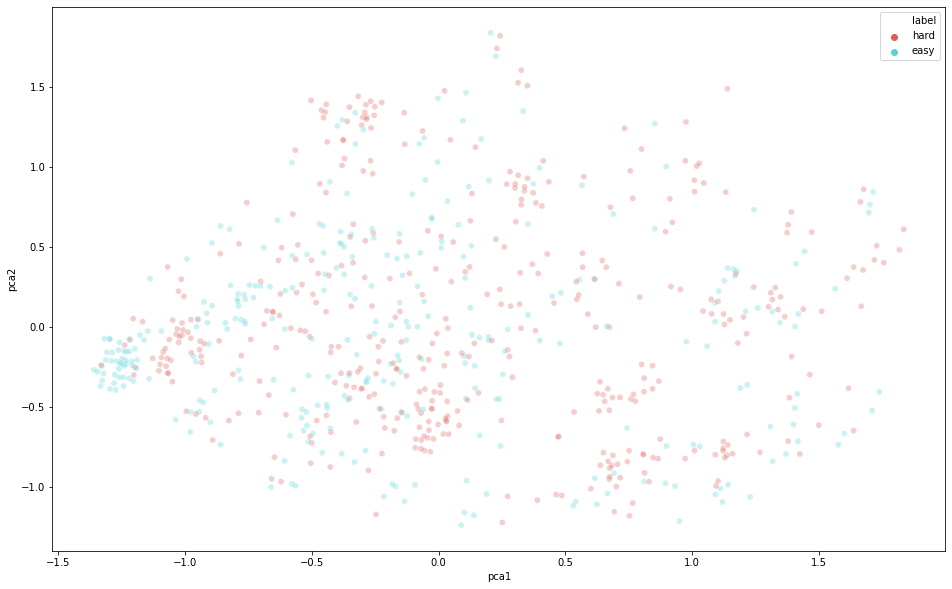

In [11]:
n_colors = 2  # len(labels)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca1", y="pca2",
    hue="label",
    palette=sns.color_palette("hls", n_colors),
    data=df.loc[rndperm,:],   # rndperm is redundant here
    legend="full",
    alpha=0.3
)

### Visualizing LOINC: t-SNE

In [12]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=15, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 722 samples in 0.003s...
[t-SNE] Computed neighbors for 722 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 722 / 722
[t-SNE] Mean sigma: 0.907795
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.228485
[t-SNE] KL divergence after 300 iterations: 1.398070
t-SNE done! Time elapsed: 1.1630401611328125 seconds


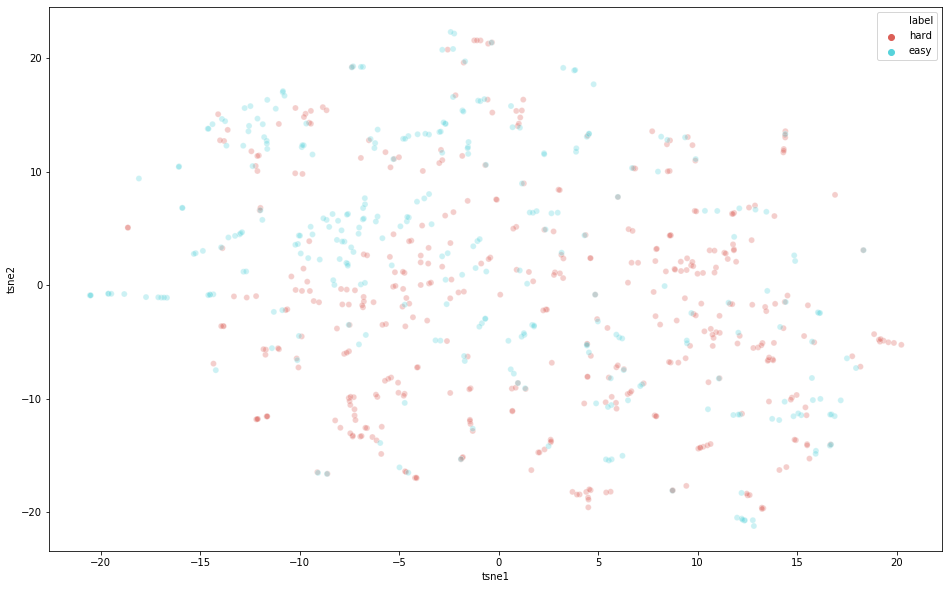

In [13]:
df['tsne1'] = tsne_results[:,0]
df['tsne2'] = tsne_results[:,1]
plt.figure(figsize=(16,10))

# note: requires seaborn-0.9.0
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="label",
    palette=sns.color_palette("hls", n_colors),
    data=df,
    legend="full",
    alpha=0.3
)


### Error Analysis Part II

In [17]:
# {easy, hard} vs medivo test result type (MTRT)
from analyzer import label_by_performance, analyze_by_values, load_src_data
"""
Memo
----
   df: 6-parts training data
   codes_easy = df.loc[df['label'] == 'easy'][ 'code' ].values
   codes_hard = df.loc[df['label'] == 'hard'][ 'code' ].values

"""
cohort = 'hepatitis-c'

categories = ['easy', 'hard', 'low']  # low: low sample size
ccmap = label_by_performance(cohort='hepatitis-c', categories=categories)
assert len(ccmap) == len(categories), "n(ccmap): {} <> n(cat): {}".format(len(ccmap), len(categories))

# a dictionary of LOINC table dataframes indexed by analysis categories (e.g. easy, hard)
D = analyze_by_values(ccmap, verbose=0) # 
print("> key(D): {}".format(D.keys()))

# easy cases
df0 = D['easy']
df1 = D['hard']
df2 = D['low']
# ... ['LOINC_NUM' 'LONG_COMMON_NAME' 'SHORTNAME' 'RELATEDNAMES2' 
# ...  'STATUS_TEXT' 'PROPERTY' 'TIME_ASPCT' 'SYSTEM' 'METHOD_TYP' 'SCALE_TYP' 'CLASS']

# [todo] somehow the following assertion is not always true! 
# for cat in categories: 
#     assert len(ccmap[cat]) == D[cat].shape[0], "{} <> {}".format(len(ccmap[cat]), D[cat].shape[0])

col_key = 'LOINC_NUM'
cohort = 'hepatitis-c'
print("> col(df_easy): {} | dim(df0): {}".format(df0.columns.values, df0.shape))
codes_src = load_loinc_table(dehyphenate=True)['LOINC_NUM'].values 
codes_target = load_performance(input_dir='result', cohort=cohort)['code'].values

codes_easy = df0[col_key].values
codes_hard = df1[col_key].values 
codes_low =  df2[col_key].values
codes_missed = list(set(codes_target)-set(codes_src))
print("> n(easy): {}, n(hard): {}, n(low): {}".format(len(codes_easy), len(codes_hard), len(codes_low)))
print("> n(missed): {}".format(len(codes_missed)))
      
#####################################################################
# Total number of codes: 733 | n(low_sample): 273(37.244%), n(scored):460(62.756%), n(high scored):386(52.66%)

> dim(performance matrix): (733, 5)
(label_by_performance) dim(df_perf): (733, 5)
1. Total number of codes: 733 | n(low_sample): 422(57.572%), n(scored):311(42.428%), n(high scored):308(42.019%)
2. Pecentage scored codes: 42.428%
3. Percentage "good" codes: 42.019%
> dim(table): (92369, 46)
> key(D): dict_keys(['easy', 'hard', 'low'])
> col(df_easy): ['LOINC_NUM' 'LONG_COMMON_NAME' 'SHORTNAME' 'RELATEDNAMES2' 'STATUS_TEXT'
 'COMPONENT' 'PROPERTY' 'TIME_ASPCT' 'SYSTEM' 'SCALE_TYP' 'METHOD_TYP'
 'COMPONENT' 'PROPERTY' 'TIME_ASPCT' 'SYSTEM' 'SCALE_TYP' 'METHOD_TYP'
 'CLASS'] | dim(df0): (305, 18)
> dim(table): (92369, 46)
> dim(performance matrix): (733, 5)
> n(easy): 305, n(hard): 2, n(low): 415
> n(missed): 11


#### Error Analysis II: EDA

In [18]:
def has_null(df, cols=['test_result_name', 'test_result_value', ]): 
    for col in cols: 
        if df[col].isnull().values.any(): 
            return True
    return False
def subset_by_null(df, cols=['test_result_name', 'test_result_value', ]): 
    tvals = np.array([True] * df.shape[1])
    for i, col in enumerate(cols): 
    
        if i == 0: 
            tvals = df[col].isnull().values
        else: 
            tvals = np.logical_or(tvals, df[col].isnull().values)
            
    if np.sum(tvals) > 0: 
        return df[tvals]
    return DataFrame()  # dummy

from loinc import make_6p

# MTRT dataframe / training data
df = load_src_data(cohort=cohort, verbose=1)  # the original training data with relevant MTRT attributes
N0 = df.shape[0]

# drop duplicates # e.g. df.drop_duplicates(subset=['launched', 'code'], keep='last')
df = df.drop_duplicates(keep='last')  
N = df.shape[0]
print(f"> Drop dup | n(before): {N0} >? n(after): {N}")

# ... ['test_order_code' 'test_order_name' 'test_result_code' 'test_result_name' 'test_result_value' 
# ...  'test_result_range' ... ]
print("> col(df): {}\n".format(df.columns.values))
col_key_mtrt = 'test_result_loinc_code'

col_key = 'LOINC_NUM'
n_to_process = 0
tShowAll = False
for cat in ['hard', 'low']: 
    
    print(f"> Inspecting '{cat}' codes")
    dfl = D[cat]
    codes = dfl[col_key].values
    for i, code in enumerate(codes): # foreach code found in the loinc table
        ieff = i+1
        
        # 6 parts 
        six_parts = make_6p(dfl, code)
        
        # find its corresponding patient attributes in the original training data
        dfe = df.loc[df[col_key_mtrt] == code] 
        
        # find the sample size (n_pos)
        N = df_perf[df_perf['code'] == code]['n_pos'].iloc[0]  # ['code', 'mean', 'std', 'n_pos']

        msg = ""
        if tShowAll or has_null(dfe, cols=['test_result_name', 'test_result_value', 'medivo_test_result_type']): 
            
            n0 = dfe.shape[0]
            dfe = subset_by_null(dfe, cols=['test_result_name', 'test_result_value', 'medivo_test_result_type'])
            n = dfe.shape[0]
            print("> n(matched): {} -> {}".format(n0, n))  # this is usually > 1
            
            if n > 0: 
                dfe = dfe.sample(n=min(2, n))

                msg += "[{}] {} (N={}) => \n".format(ieff, code, N)
                msg += "    + 6 parts:          {}\n".format(six_parts)
                msg += "    + test_order_code:  {}\n".format(dfe['test_order_code'].values)
                msg += "    + test_order_name:  {}\n".format(dfe['test_order_name'].values)
                # msg += "    + test_result_code: {}\n".format(dfe['test_result_code'].values)
                msg += "    + test_result_name: {}\n".format(dfe['test_result_name'].values)
                msg += "    + test_result_value: {}\n".format(dfe['test_result_value'].values)
                
                msg += "-" * 50 + '\n'
                if 'test_result_comments' in dfe.columns: 
                    msg += "    + test_result_comments: {}\n".format(dfe['test_result_comments'].values)
                msg += "    + medivo_test_result_type: {}\n".format(dfe['medivo_test_result_type'].values)
                print(msg)
                

[load] Loading default input data: andromeda-pond-hepatitis-c.csv


b'Skipping line 2834: expected 127 fields, saw 128\n'
b'Skipping line 9920: expected 127 fields, saw 128\nSkipping line 10806: expected 127 fields, saw 128\n'
b'Skipping line 16962: expected 127 fields, saw 128\nSkipping line 17264: expected 127 fields, saw 128\nSkipping line 20551: expected 127 fields, saw 129\nSkipping line 23730: expected 127 fields, saw 128\n'
b'Skipping line 27323: expected 127 fields, saw 128\nSkipping line 27766: expected 127 fields, saw 128\nSkipping line 30213: expected 127 fields, saw 128\n'
b'Skipping line 33681: expected 127 fields, saw 128\nSkipping line 34672: expected 127 fields, saw 128\nSkipping line 36828: expected 127 fields, saw 129\nSkipping line 38755: expected 127 fields, saw 128\nSkipping line 38985: expected 127 fields, saw 128\n'
b'Skipping line 43025: expected 127 fields, saw 128\nSkipping line 44345: expected 127 fields, saw 128\nSkipping line 45396: expected 127 fields, saw 128\nSkipping line 46299: expected 127 fields, saw 128\nSkipping li

(canonicalize) Operations: fill n/a + dehyphenate + replace_values + trim_tail + fill others (non-target classes)
> Drop dup | n(before): 71224 >? n(after): 71224
> col(df): ['meta_package_key' 'input_filename' 'patient_date_of_birth'
 'patient_gender' 'patient_state' 'patient_bill_type' 'diagnosis_codes'
 'diagnosis_descriptions' 'laboratory_diagnosis' 'billing_diagnosis_codes'
 'insurance_company_id' 'insurance_company_name' 'fasting'
 'performing_organization_id' 'performing_organization_name'
 'performing_organization_address_line_1'
 'performing_organization_address_line_2' 'performing_organization_city'
 'performing_organization_state' 'performing_organization_zip_code'
 'analyzing_organization_id' 'analyzing_organization_name'
 'analyzing_organization_address_line_1'
 'analyzing_organization_address_line_2' 'analyzing_organization_city'
 'analyzing_organization_state' 'analyzing_organization_zip_code'
 'receiving_organization_id' 'receiving_organization_name'
 'receiving_organiz


> n(matched): 2 -> 2
[38] 142976 (N=2) => 
    + 6 parts:          COMPONENT    Thyrotropin
COMPONENT    Thyrotropin
Name: 4762, dtype: object|PROPERTY    SCnc
PROPERTY    SCnc
Name: 4762, dtype: object|TIME_ASPCT    Pt
TIME_ASPCT    Pt
Name: 4762, dtype: object|SYSTEM    Ser/Plas
SYSTEM    Ser/Plas
Name: 4762, dtype: object|SCALE_TYP    Qn
SCALE_TYP    Qn
Name: 4762, dtype: object|METHOD_TYP    NaN
METHOD_TYP    NaN
Name: 4762, dtype: object
    + test_order_code:  ['TSH' 'TSH']
    + test_order_name:  ['THYROID STIMULATING HORMONE' 'THYROID STIMULATING HORMONE']
    + test_result_name: ['TSH' 'TSH']
    + test_result_value: ['0.667' '4.886']
--------------------------------------------------
    + test_result_comments: [nan nan]
    + medivo_test_result_type: [nan nan]

> n(matched): 1 -> 1
[48] 150748 (N=1) => 
    + 6 parts:          COMPONENT    Glucose
COMPONENT    Glucose
Name: 5625, dtype: object|PROPERTY    SCnc
PROPERTY    SCnc
Name: 5625, dtype: object|TIME_ASPCT    Pt
TIME


> n(matched): 1 -> 1
[102] 19620 (N=1) => 
    + 6 parts:          COMPONENT    Bicarbonate
COMPONENT    Bicarbonate
Name: 10471, dtype: object|PROPERTY    SCnc
PROPERTY    SCnc
Name: 10471, dtype: object|TIME_ASPCT    Pt
TIME_ASPCT    Pt
Name: 10471, dtype: object|SYSTEM    Plas
SYSTEM    Plas
Name: 10471, dtype: object|SCALE_TYP    Qn
SCALE_TYP    Qn
Name: 10471, dtype: object|METHOD_TYP    NaN
METHOD_TYP    NaN
Name: 10471, dtype: object
    + test_order_code:  ['905']
    + test_order_name:  ['COMPREHENSIVE METABOLIC PANEL WITH GFR']
    + test_result_name: ['CO2']
    + test_result_value: ['24']
--------------------------------------------------
    + test_result_comments: [nan]
    + medivo_test_result_type: [nan]

> n(matched): 4 -> 4
[103] 196428 (N=4) => 
    + 6 parts:          COMPONENT    oxyCODONE
COMPONENT    oxyCODONE
Name: 10492, dtype: object|PROPERTY    PrThr
PROPERTY    PrThr
Name: 10492, dtype: object|TIME_ASPCT    Pt
TIME_ASPCT    Pt
Name: 10492, dtype: object|SYS


> n(matched): 1 -> 1
[146] 257006 (N=1) => 
    + 6 parts:          COMPONENT    Interpretation
COMPONENT    Interpretation
Name: 17101, dtype: object|PROPERTY    Imp
PROPERTY    Imp
Name: 17101, dtype: object|TIME_ASPCT    Pt
TIME_ASPCT    Pt
Name: 17101, dtype: object|SYSTEM    Ser/Plas
SYSTEM    Ser/Plas
Name: 17101, dtype: object|SCALE_TYP    Nom
SCALE_TYP    Nom
Name: 17101, dtype: object|METHOD_TYP    Immunofixation
METHOD_TYP    Immunofixation
Name: 17101, dtype: object
    + test_order_code:  ['4600000549']
    + test_order_name:  ['IMMUNOFIXATION, SERUM']
    + test_result_name: ['INTERPRETATION']
    + test_result_value: [nan]
--------------------------------------------------
    + test_result_comments: ['A poorly-defined area of restricted protein mobility is detected and is reactive with IgG and lambda antisera.  G. Hortin, MD']
    + medivo_test_result_type: ['Protein Fractions [Interpretation] in Serum or Plasma by Electrophoresis Narrative']

> n(matched): 1 -> 1
[147]


> n(matched): 2 -> 2
[205] 332569 (N=2) => 
    + 6 parts:          COMPONENT    Leukocytes^^corrected for nucleated erythrocytes
COMPONENT    Leukocytes^^corrected for nucleated erythrocytes
Name: 25425, dtype: object|PROPERTY    NCnc
PROPERTY    NCnc
Name: 25425, dtype: object|TIME_ASPCT    Pt
TIME_ASPCT    Pt
Name: 25425, dtype: object|SYSTEM    Bld
SYSTEM    Bld
Name: 25425, dtype: object|SCALE_TYP    Qn
SCALE_TYP    Qn
Name: 25425, dtype: object|METHOD_TYP    Automated count
METHOD_TYP    Automated count
Name: 25425, dtype: object
    + test_order_code:  ['CBC74' 'CBC74']
    + test_order_name:  ['CBC' 'CBC']
    + test_result_name: ['WBC' 'WBC']
    + test_result_value: ['3.2' '5.8']
--------------------------------------------------
    + test_result_comments: [nan nan]
    + medivo_test_result_type: [nan nan]

> n(matched): 1 -> 1
[215] 347005 (N=1) => 
    + 6 parts:          COMPONENT    HIV reverse transcriptase+Protease gene mutati...
COMPONENT    HIV reverse transcriptase


> n(matched): 3 -> 3
[241] 429316 (N=3) => 
    + 6 parts:          COMPONENT    Chlamydia trachomatis rRNA
COMPONENT    Chlamydia trachomatis rRNA
Name: 35955, dtype: object|PROPERTY    PrThr
PROPERTY    PrThr
Name: 35955, dtype: object|TIME_ASPCT    Pt
TIME_ASPCT    Pt
Name: 35955, dtype: object|SYSTEM    Urine
SYSTEM    Urine
Name: 35955, dtype: object|SCALE_TYP    Ord
SCALE_TYP    Ord
Name: 35955, dtype: object|METHOD_TYP    Probe.amp.tar
METHOD_TYP    Probe.amp.tar
Name: 35955, dtype: object
    + test_order_code:  ['4112' '5399']
    + test_order_name:  ['CT/NG, TMA, URINE' 'CHLAMYDIA, TMA, URINE']
    + test_result_name: ['CHLAMYDIA BY TMA' 'CHLAMYDIA, TMA']
    + test_result_value: ['TNP' 'NEGATIVE']
--------------------------------------------------
    + test_result_comments: ['Unable to perform testing, specimen not received. Charges adjusted as applicable.'
 'Assay methodology is nucleic acid amplification by transcription  mediated amplification (TMA) utilizing the Aptima


> n(matched): 2 -> 2
[280] 509570 (N=2) => 
    + 6 parts:          COMPONENT    Manual differential performed
COMPONENT    Manual differential performed
Name: 44862, dtype: object|PROPERTY    PrThr
PROPERTY    PrThr
Name: 44862, dtype: object|TIME_ASPCT    Pt
TIME_ASPCT    Pt
Name: 44862, dtype: object|SYSTEM    Bld
SYSTEM    Bld
Name: 44862, dtype: object|SCALE_TYP    Ord
SCALE_TYP    Ord
Name: 44862, dtype: object|METHOD_TYP    NaN
METHOD_TYP    NaN
Name: 44862, dtype: object
    + test_order_code:  ['H010' 'H010']
    + test_order_name:  ['CBC WITH AUTO DIFF' 'CBC WITH AUTO DIFF']
    + test_result_name: ['Manual Differential' 'Manual Differential']
    + test_result_value: ['Not Performed' 'Test not performed']
--------------------------------------------------
    + test_result_comments: [nan nan]
    + medivo_test_result_type: [nan nan]

> n(matched): 1 -> 1
[303] 530170 (N=1) => 
    + 6 parts:          COMPONENT    Sjogrens syndrome-A extractable nuclear 52kD Ab
COMPONENT    


> n(matched): 1 -> 1
[348] 634642 (N=1) => 
    + 6 parts:          COMPONENT    Treponema pallidum Ab
COMPONENT    Treponema pallidum Ab
Name: 58552, dtype: object|PROPERTY    ACnc
PROPERTY    ACnc
Name: 58552, dtype: object|TIME_ASPCT    Pt
TIME_ASPCT    Pt
Name: 58552, dtype: object|SYSTEM    Ser
SYSTEM    Ser
Name: 58552, dtype: object|SCALE_TYP    Qn
SCALE_TYP    Qn
Name: 58552, dtype: object|METHOD_TYP    IA
METHOD_TYP    IA
Name: 58552, dtype: object
    + test_order_code:  ['195']
    + test_order_name:  ['Treponema pallidum Antibodies']
    + test_result_name: ['Treponema pallidum Antibodies']
    + test_result_value: ['<0.100']
--------------------------------------------------
    + test_result_comments: ['Reference Range for T. pallidum Abs Result Status Interpretation < 0.9 Non-Reactive No serological evidence of infection with Treponema pallidum. 0.9 - 1.0 Equivocal Suggest obtaining an additional sample for re-testing. > 1.0 Reactive Presumptive evidence of current infe


> n(matched): 1 -> 1
[369] 747931 (N=1) => 
    + 6 parts:          COMPONENT    Thyroid hormone uptake
COMPONENT    Thyroid hormone uptake
Name: 70858, dtype: object|PROPERTY    NFr
PROPERTY    NFr
Name: 70858, dtype: object|TIME_ASPCT    Pt
TIME_ASPCT    Pt
Name: 70858, dtype: object|SYSTEM    Ser/Plas
SYSTEM    Ser/Plas
Name: 70858, dtype: object|SCALE_TYP    Qn
SCALE_TYP    Qn
Name: 70858, dtype: object|METHOD_TYP    NaN
METHOD_TYP    NaN
Name: 70858, dtype: object
    + test_order_code:  ['19275']
    + test_order_name:  ['PCPAP MALE PROFILE']
    + test_result_name: ['T-UPTAKE']
    + test_result_value: ['36.1']
--------------------------------------------------
    + test_result_comments: [nan]
    + medivo_test_result_type: [nan]

> n(matched): 1 -> 1
[370] 747956 (N=1) => 
    + 6 parts:          COMPONENT    Total thyroxine binding capacity
COMPONENT    Total thyroxine binding capacity
Name: 70860, dtype: object|PROPERTY    RelRto
PROPERTY    RelRto
Name: 70860, dtype: objec

> n(matched): 3 -> 3
[402] 825216 (N=3) => 
    + 6 parts:          COMPONENT    Paritaprevir
COMPONENT    Paritaprevir
Name: 79300, dtype: object|PROPERTY    Susc
PROPERTY    Susc
Name: 79300, dtype: object|TIME_ASPCT    Pt
TIME_ASPCT    Pt
Name: 79300, dtype: object|SYSTEM    Isolate
SYSTEM    Isolate
Name: 79300, dtype: object|SCALE_TYP    Ord
SCALE_TYP    Ord
Name: 79300, dtype: object|METHOD_TYP    Genotyping
METHOD_TYP    Genotyping
Name: 79300, dtype: object
    + test_order_code:  ['90924' '91383']
    + test_order_name:  ['HEPATITIS C VIRAL RNA GENOTYPE 1 NS' 'HCV RNA GENOTYPE 1 NS3']
    + test_result_name: ['PARITAPREVIR RESISTANCE' 'PARITAPREVIR RESISTANCE']
    + test_result_value: [nan 'TNP']
--------------------------------------------------
    + test_result_comments: ['Test not performed at Focus Diagnostics, inc.' nan]
    + medivo_test_result_type: [nan nan]

> n(matched): 1 -> 1
[403] 825232 (N=1) => 
    + 6 parts:          COMPONENT    Grazoprevir
COMPONENT    Gra

#### Error Analysis: Rule-based Predictor